## Computational Intelligence: Genetic Algorithms Project. 

In a broad sense, Genetic Algorithms can be defined as population based models that
use selection and recombination operators to generate new sample points ina search space. The idea of Genetic Algorithms are heavily infuenced by the Theory of Evolution, by encoding potential solutions to a specific problem into simple chromosome-like data structure and apply recombination operators to these structures, as to preserve critical information.

The goal of this project is to use a Genetic Algorithm to find the best words that complete a damaged Greek inscription, using other inscriptions found in the same area. Given this goal, the influence of different hyperparametes to the final results, such as crossover and mutation probabilities, number of individuals in the population, etc. are also examined. 


In [15]:
import pandas as pd
import numpy as np 
from difflib import get_close_matches
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import utils as ul

<module 'utils' from 'c:\\Users\\kwnka\\vs-code projects\\CompIntel\\project_B\\utils.py'>

### Preprocessing

1. **Loading**: To start off the dataset is loaded into a Pandas dataframe and some information is printed using the `print_dataframe_info()` function, to help understand the data better. Then we filter the dataframe, keeping the data having `region_main_id == 1693`. This means that only the inscriptions of the particular region of the damaged inscription are kept, which have a generally higher chance to have similar content.
2. **BoW with Tf-Idf**: In order to implement the Bag of Words model using tf-idf vectorization, the following steps are performed:
    * An object of the `TfidfVectorizer()` Class is instantiated.
    * The method `fit_transform()` of the Class is called for this object in order for the vocabulary to be constructed and for the inscriptions to be transformed into the appropriate form.
    * The **output** of the vectorizer is a **sparse matrix**, where the rows are the different inscriptions and columns the different features of the vocabulary. A value in a particular position of the matrix signifies the existance of the particular feature in that inscription.
3. **Target Inscription**: Since the damaged inscription that needs to be filled is not part of the dataset, the word *αλεξανδρε* does not exist in the vocabulary built using the BoW, so it is replaced by the closest related word in the dictionary, the word *ανδρες*, which is found using the `get_close_matches(missing_word, vocab, n=1)` command from the `difflib` library, where:
    * **missing word**: Is the word that is missing, so the word *αλεξανδρε*.
    * **vocab**: Is the vocabulary obtained from the `print_vectorizer_info()` function.
    * **n=1**: Signifies that the closest possible word to the missing word should be returned.
    
So the new target inscription after this procedure is [...]*ανδρες ουδις*[...], which is then tranformed into a tf-idf vector using the same vectorizer as before.

The three seperate steps of the preprocessing can be seen below:

In [16]:
# Load dataset into a dataframe and print information about it
df = pd.read_csv('iphi2802.csv', delimiter='\t')

ul.print_dataframe_info(df)

df_filtered= df.query("region_main_id == 1693")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2802 non-null   int64  
 1   text            2802 non-null   object 
 2   metadata        2802 non-null   object 
 3   region_main_id  2802 non-null   int64  
 4   region_main     2802 non-null   object 
 5   region_sub_id   2802 non-null   int64  
 6   region_sub      2802 non-null   object 
 7   date_str        2802 non-null   object 
 8   date_min        2802 non-null   float64
 9   date_max        2802 non-null   float64
 10  date_circa      2802 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 240.9+ KB

Number of NULL values per column:
id                0
text              0
metadata          0
region_main_id    0
region_main       0
region_sub_id     0
region_sub        0
date_str          0
date_min          0
date_ma

In [17]:
# Initalize the tf-idf Vectorizer 
vectorizer = TfidfVectorizer()
index_matrix = vectorizer.fit_transform(df_filtered['text'].to_list()).toarray()

vocab_dict = ul.print_vectorizer_info(vectorizer, index_matrix, True)

The dictionary of the dataset: ['αβ' 'αββεος' 'αβδαασθωρης' ... 'ϙε' 'ϙτ' 'ϛπ']
The shape of the output matrix: (127, 1678)
The matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The unique values of the output matrix: [0.         0.01130775 0.01235026 0.01388891 0.01461941 0.01556119
 0.01688855 0.02016224 0.02100191 0.0212497  0.02392936 0.02777781
 0.02923882 0.03060018 0.03112238 0.0330687  0.03345886 0.03377711
 0.03527057 0.03589404 0.03631753 0.03748793 0.03836221 0.03881482
 0.03987613 0.04166672 0.04215832 0.04385823 0.04437568 0.04668357
 0.04723436 0.04911755 0.04940106 0.05066566 0.05099229 0.05126343
 0.05146199 0.05316818 0.05515732 0.05555563 0.05774379 0.06008614
 0.06048671 0.06175797 0.06248299 0.06297707 0.06493779 0.06499394
 0.06604416 0.06754861 0.06755421 0.06778379 0.06920439 0.06933822
 0.06944454 0.06971857 0.07178808 0.07198476 0.07221305 0.0730970

In [18]:
# Find the word closest to the missing word 'αλεξανδρε' and turn the incomplete inscription into a tf-idf vector
missing_word = 'αλεξανδρε'
replaced_word = get_close_matches(missing_word, vocab_dict.values(), n=1)
print(f"The word closest to the missing word: {replaced_word[0]}")
replaced_inscription = f'{replaced_word[0]} ουδις'
print(f"The new inscription: {replaced_inscription}")
incomplete_vector = vectorizer.transform([replaced_inscription]).toarray()

The word closest to the missing word: ανδρες
The new inscription: ανδρες ουδις


### Encoding of chromosomes & Fitness Function

* **Encoding**: Firstly, the chromosomes of the population, consist of two different genes, one for each word that is missing. For this project the different genes, hence the chromosomes of the population are encoded using integer value encoding. Since the dictionary of this project consists of 1678 different features, the different values of a gene will be 0-1677. The final chromosome is a tuple consisting of two numbers, which are the indexes of the words in the dictionary. 
Using this particular encoding ensures that no values outside of the range 0-1677 will occur. To ensure this, the gene space has been inserted to the constructor of the GA instance.

* **Find_k_nearest Function**: This is a custom function that was built for this project and it's goal is to find the k nearest vectors to the target vector, using the cosine similarity metric. In this project though, vectors are of a high dimensionality and really sparse, so the cosine similarity between them is expected to generally be close to or zero.

* **Fitness Function**: The custom fitness function completes the inscription, by concatenating the two corresponding words from the two genes of the chromosome. It then transforms the filled-in target inscription to a tf-idf vector using the same vectorizer as before and compares it to the top-k inscriptions found earlier. The mean of those values is the fitness value of the particular chromosome.


In [19]:
# Find the top k closest neighbours to the incomplete inscription.
top_indices, top_values = ul.find_k_nearest(5, index_matrix, incomplete_vector)

# Fitness function to use with GA
def fitness_func(ga_instance, solution, solution_idx):
    left_word_idx, right_word_idx = solution
    
    left_word = vocab_dict[left_word_idx]
    right_word = vocab_dict[right_word_idx]
    replaced_inscription = f'{left_word} αλεξανδρε ουδις {right_word}'
    
    replaced_vector = vectorizer.transform([replaced_inscription]).toarray().reshape(1, -1)
    fit_similarities = []
    
    for index in top_indices:
        inscription = index_matrix[index].reshape(1, -1)
        similarity = cosine_similarity(inscription, replaced_vector)[0][0]
        fit_similarities.append(similarity)
    fitness_value = np.mean(fit_similarities)
    
    mean_value = np.mean(top_values)
    
    # Punishing chromosomes with suboptimal fitness values, to discourage them from continuing
    if fitness_value < mean_value:
        fitness_value = fitness_value - (0.5 * fitness_value)
    
    return fitness_value
    

### Early Stopping Callback Function

This custom function stops the genetic algorithm prematurely if one or two of the conditions, which are described below, is satisfied:

1. The best chromosome of each generation stops evolving for a specific number of generations.
2. The best chromosome of each generation has an evolving rate less than 1%, or
3. The predifined number of generations has been reached.



In [20]:
best_fitness_values = []
num_of_insignificant_better = []
num_of_insignificant_better.append(0)

#Stop early when GA converges
def early_stopping_callback(ga_instance):
    best_fitness_values.append(ga_instance.best_solution()[1])
        
    better_ratio = (best_fitness_values[len(best_fitness_values)-1] / best_fitness_values[len(best_fitness_values)-2]) - 1
    if better_ratio < 0.01 and len(best_fitness_values) > 1:
        num_of_insignificant_better.append(num_of_insignificant_better[len(num_of_insignificant_better)-1] + 1)
    else:
        num_of_insignificant_better.append(0)
    
    if num_of_insignificant_better[len(num_of_insignificant_better)-1] == 100:
        return "stop"

### Genetic Algorithm Instance

The goal is to observe the behavior of the genetic algorithm for different values of individuals in the population as well as different crossover and mutation probabilities. With that in mind, the genetic algorithm is constructed to run with each set of parameters for 10 randomly initialized populations. 

The initial populations are constructed using **Latin Hypercube Sampling**, which is a method that produces more evenly spaced random points of a certain space. Given that Genetic Algorithms are somewhat of a stocastic procedure, the average performance of the best solution for each initial population and for each set of parameters is chosen to be plotted.  

The **pyGAD** library is chosen to implement the Genetic Algorithm. First it is needed to initialize the needed parameters. These parameters can be see in the `set_ga_instances()` of the `utils.py` file. Each of the parameters is explained in the official [documentation](https://pygad.readthedocs.io/en/latest/pygad.html#other-attributes).

In the diagrams below, we can see the average fitness per generation for each set of the different parameters and we can also see the generation the Genetic Algorith stopped for each initial population.


Execution for population of 20, crossover probability of 0.6 and mutation probability of 0.0:

Execution 1:
Stopped Execution at Generation 0.
Execution 2:
Stopped Execution at Generation 0.
Execution 3:
Stopped Execution at Generation 0.
Execution 4:
Stopped Execution at Generation 0.
Execution 5:
Stopped Execution at Generation 1.
Execution 6:
Stopped Execution at Generation 2.
Execution 7:
Stopped Execution at Generation 2.
Execution 8:
Stopped Execution at Generation 2.
Execution 9:
Stopped Execution at Generation 3.
Execution 10:
Stopped Execution at Generation 3.
The best average fitness value was 0.1102371504252873 and was reached in the average generation of 1.3.



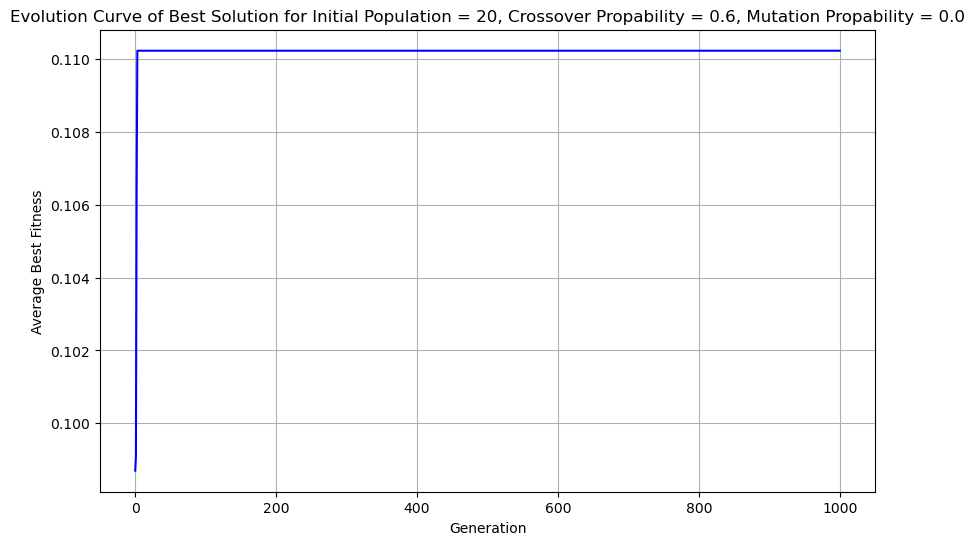

Execution for population of 20, crossover probability of 0.6 and mutation probability of 0.01:

Execution 1:
Stopped Execution at Generation 168.
Execution 2:
Stopped Execution at Generation 98.
Execution 3:
Stopped Execution at Generation 92.
Execution 4:
Stopped Execution at Generation 189.
Execution 5:
Stopped Execution at Generation 205.
Execution 6:
Stopped Execution at Generation 2.
Execution 7:
Stopped Execution at Generation 24.
Execution 8:
Stopped Execution at Generation 73.
Execution 9:
Stopped Execution at Generation 73.
Execution 10:
Stopped Execution at Generation 27.
The best average fitness value was 0.20674993103826605 and was reached in the average generation of 95.1.



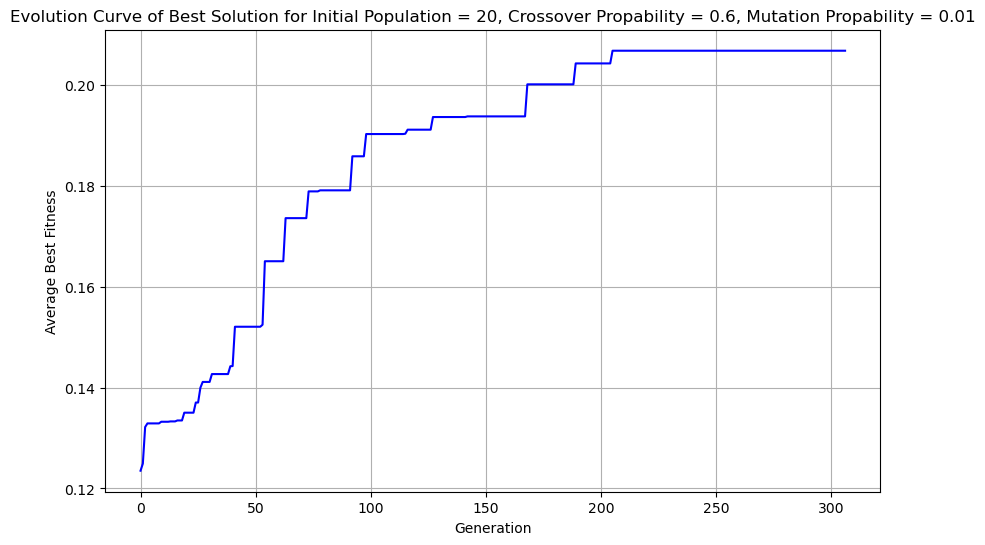

Execution for population of 20, crossover probability of 0.6 and mutation probability of 0.1:

Execution 1:
Stopped Execution at Generation 38.
Execution 2:
Stopped Execution at Generation 270.
Execution 3:
Stopped Execution at Generation 165.
Execution 4:
Stopped Execution at Generation 110.
Execution 5:
Stopped Execution at Generation 162.
Execution 6:
Stopped Execution at Generation 99.
Execution 7:
Stopped Execution at Generation 237.
Execution 8:
Stopped Execution at Generation 201.
Execution 9:
Stopped Execution at Generation 104.
Execution 10:
Stopped Execution at Generation 66.
The best average fitness value was 0.24202874251624085 and was reached in the average generation of 145.2.



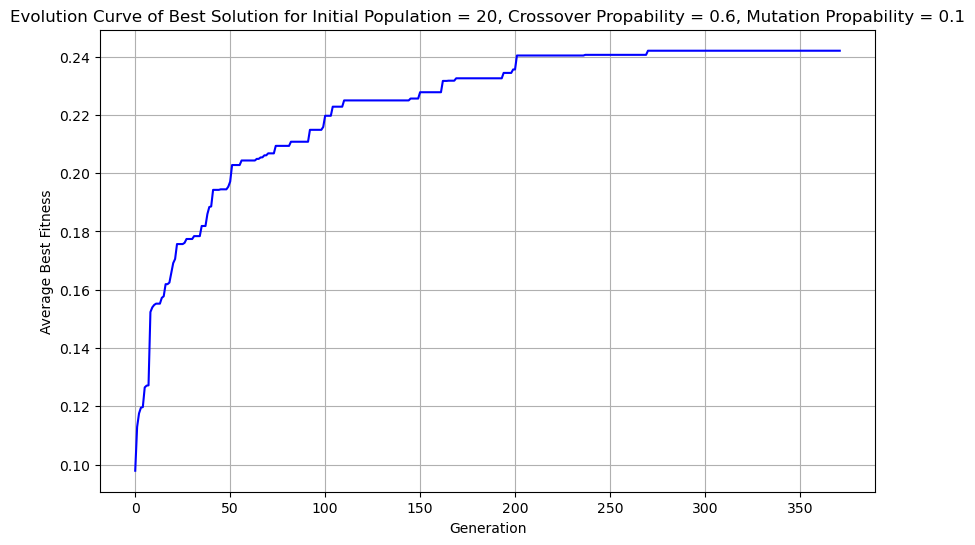

Execution for population of 20, crossover probability of 0.9 and mutation probability of 0.01:

Execution 1:
Stopped Execution at Generation 19.
Execution 2:
Stopped Execution at Generation 73.
Execution 3:
Stopped Execution at Generation 222.
Execution 4:
Stopped Execution at Generation 3.
Execution 5:
Stopped Execution at Generation 117.
Execution 6:
Stopped Execution at Generation 114.
Execution 7:
Stopped Execution at Generation 2.
Execution 8:
Stopped Execution at Generation 164.
Execution 9:
Stopped Execution at Generation 37.
Execution 10:
Stopped Execution at Generation 144.
The best average fitness value was 0.17558115690877102 and was reached in the average generation of 89.5.



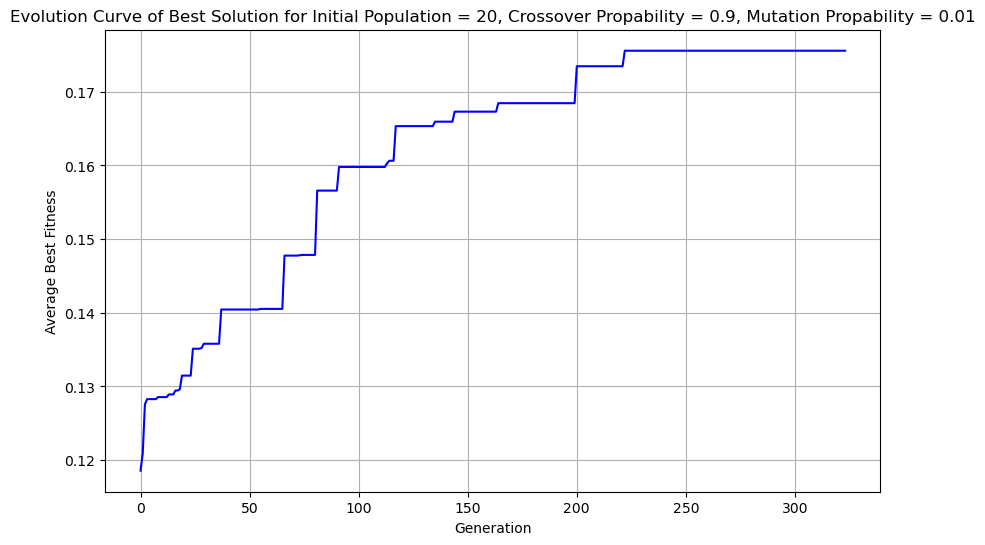

Execution for population of 20, crossover probability of 0.1 and mutation probability of 0.01:

Execution 1:
Stopped Execution at Generation 147.
Execution 2:
Stopped Execution at Generation 6.
Execution 3:
Stopped Execution at Generation 45.
Execution 4:
Stopped Execution at Generation 164.
Execution 5:
Stopped Execution at Generation 3.
Execution 6:
Stopped Execution at Generation 67.
Execution 7:
Stopped Execution at Generation 273.
Execution 8:
Stopped Execution at Generation 204.
Execution 9:
Stopped Execution at Generation 109.
Execution 10:
Stopped Execution at Generation 107.
The best average fitness value was 0.1796263109964769 and was reached in the average generation of 112.5.



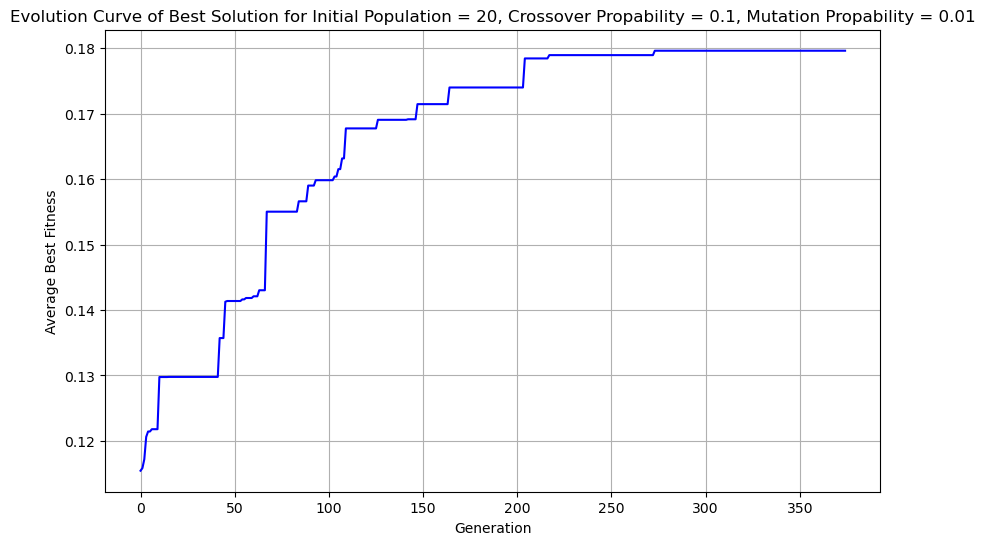

Execution for population of 200, crossover probability of 0.6 and mutation probability of 0.0:

Execution 1:
Stopped Execution at Generation 4.
Execution 2:
Stopped Execution at Generation 5.
Execution 3:
Stopped Execution at Generation 2.
Execution 4:
Stopped Execution at Generation 2.
Execution 5:
Stopped Execution at Generation 4.
Execution 6:
Stopped Execution at Generation 3.
Execution 7:
Stopped Execution at Generation 5.
Execution 8:
Stopped Execution at Generation 5.
Execution 9:
Stopped Execution at Generation 3.
Execution 10:
Stopped Execution at Generation 2.
The best average fitness value was 0.22762985902081762 and was reached in the average generation of 3.5.



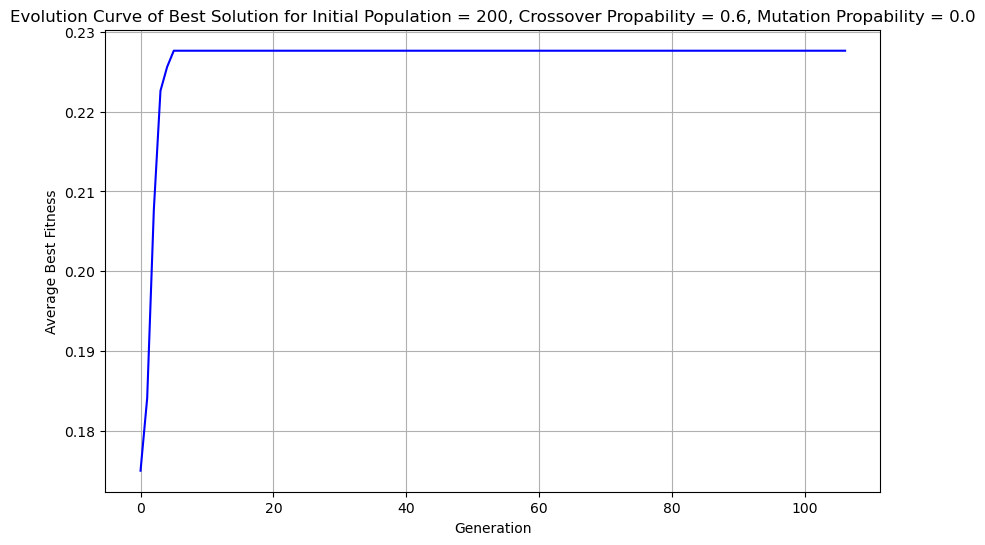

Execution for population of 200, crossover probability of 0.6 and mutation probability of 0.01:

Execution 1:
Stopped Execution at Generation 6.
Execution 2:
Stopped Execution at Generation 71.
Execution 3:
Stopped Execution at Generation 60.
Execution 4:
Stopped Execution at Generation 3.
Execution 5:
Stopped Execution at Generation 45.
Execution 6:
Stopped Execution at Generation 39.
Execution 7:
Stopped Execution at Generation 3.
Execution 8:
Stopped Execution at Generation 4.
Execution 9:
Stopped Execution at Generation 299.
Execution 10:
Stopped Execution at Generation 61.
The best average fitness value was 0.24229740957483234 and was reached in the average generation of 59.1.



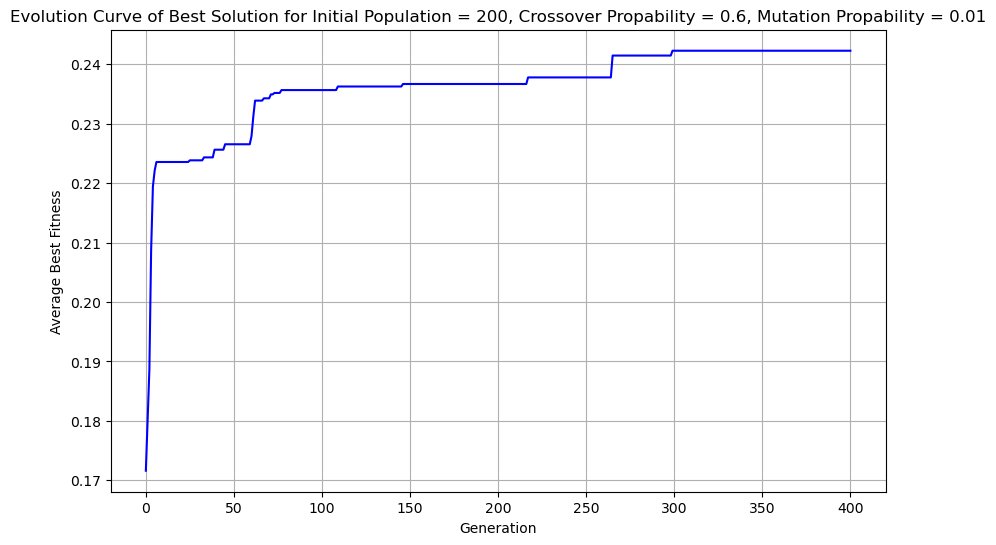

Execution for population of 200, crossover probability of 0.6 and mutation probability of 0.1:

Execution 1:
Stopped Execution at Generation 79.
Execution 2:
Stopped Execution at Generation 74.
Execution 3:
Stopped Execution at Generation 14.
Execution 4:
Stopped Execution at Generation 5.
Execution 5:
Stopped Execution at Generation 19.
Execution 6:
Stopped Execution at Generation 16.
Execution 7:
Stopped Execution at Generation 31.
Execution 8:
Stopped Execution at Generation 38.
Execution 9:
Stopped Execution at Generation 50.
Execution 10:
Stopped Execution at Generation 43.
The best average fitness value was 0.2843785063307658 and was reached in the average generation of 36.9.



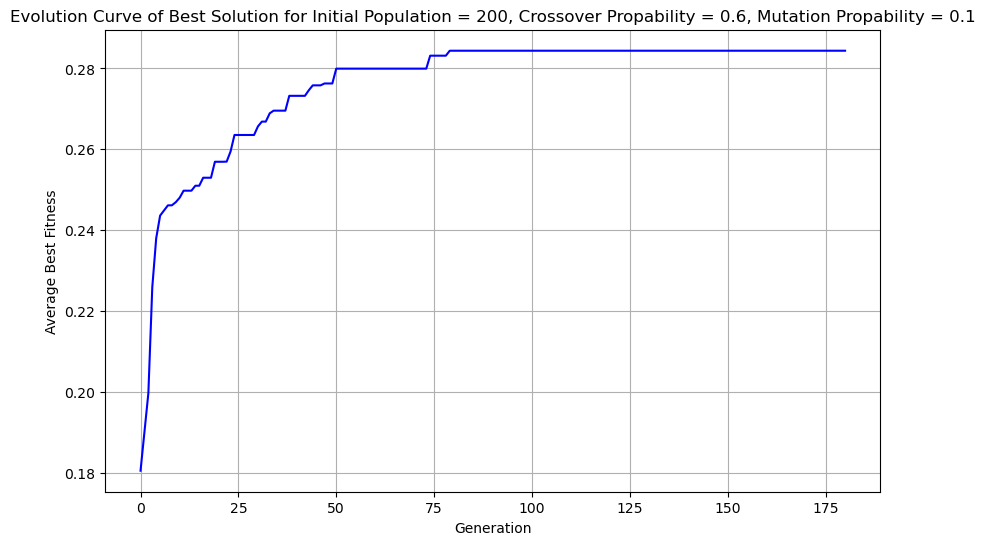

Execution for population of 200, crossover probability of 0.9 and mutation probability of 0.01:

Execution 1:
Stopped Execution at Generation 3.
Execution 2:
Stopped Execution at Generation 3.
Execution 3:
Stopped Execution at Generation 121.
Execution 4:
Stopped Execution at Generation 46.
Execution 5:
Stopped Execution at Generation 228.
Execution 6:
Stopped Execution at Generation 221.
Execution 7:
Stopped Execution at Generation 74.
Execution 8:
Stopped Execution at Generation 78.
Execution 9:
Stopped Execution at Generation 35.
Execution 10:
Stopped Execution at Generation 115.
The best average fitness value was 0.24495720789279818 and was reached in the average generation of 92.4.



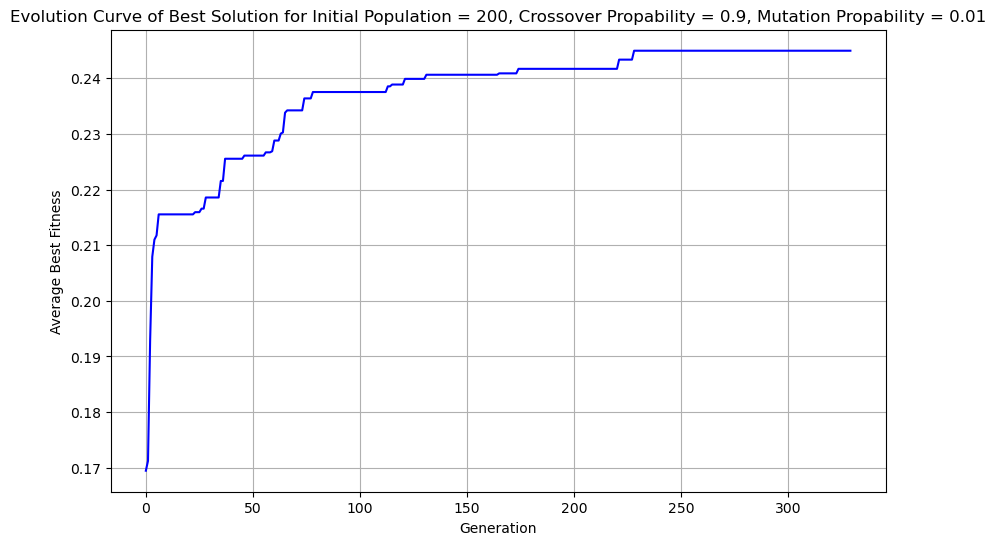

Execution for population of 200, crossover probability of 0.1 and mutation probability of 0.01:

Execution 1:
Stopped Execution at Generation 75.
Execution 2:
Stopped Execution at Generation 9.
Execution 3:
Stopped Execution at Generation 26.
Execution 4:
Stopped Execution at Generation 25.
Execution 5:
Stopped Execution at Generation 206.
Execution 6:
Stopped Execution at Generation 46.
Execution 7:
Stopped Execution at Generation 4.
Execution 8:
Stopped Execution at Generation 2.
Execution 9:
Stopped Execution at Generation 104.
Execution 10:
Stopped Execution at Generation 42.
The best average fitness value was 0.2628715023876173 and was reached in the average generation of 53.9.



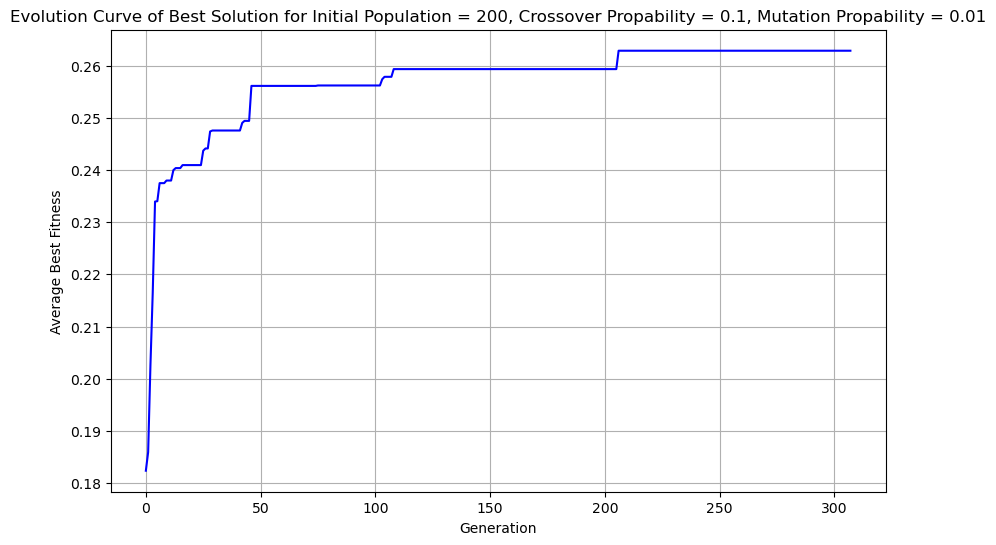

The final solution is the inscription: αθανατος αλεξανδρε ουδις θαρσι.


In [21]:
best_solution_per_instance = []
mean_stopping_generations = []
mean_best_fitness_values = []

parameters = [[20,0.6,0.0],
              [20,0.6,0.01],
              [20,0.6,0.1],
              [20,0.9,0.01],
              [20,0.1,0.01],
              [200,0.6,0.0],
              [200,0.6,0.01],
              [200,0.6,0.1],
              [200,0.9,0.01],
              [200,0.1,0.01]]

for parameter in parameters:
    print(f"Execution for population of {parameter[0]}, crossover probability of {parameter[1]} and mutation probability of {parameter[2]}:\n")
    
    initial_populations = ul.create_initial_populations(10,parameter[0])
    ga_instances = ul.set_ga_instances(initial_populations, 1000, parameter[1], parameter[2], fitness_func, early_stopping_callback)
    gen_fitness,solution,mean_ending_generation,best_mean_fitness_value = ul.run_instances(ga_instances)
    
    print(f"The best average fitness value was {best_mean_fitness_value} and was reached in the average generation of {mean_ending_generation}.\n")
    
    best_solution_per_instance.append(solution)
    mean_stopping_generations.append(mean_ending_generation)
    mean_best_fitness_values.append(best_mean_fitness_value)
    ul.plot_evolution_curve(gen_fitness, parameter[0], parameter[1], parameter[2])

# Find the best solution and complete the inscription   
best_solution = max(best_solution_per_instance, key=lambda x: x[1])[0]

word1 = vocab_dict.get(best_solution[0], "unknown")
word2 = vocab_dict.get(best_solution[1], "unknown")

final_solution = f'{word1} αλεξανδρε ουδις {word2}'

print(f"The final solution is the inscription: {final_solution}.")

   

### Results and Conclusions

As we can see each parameter affects the results in a different way;

1. **Size of Population**: Clearly, bigger population means more potential solutions and consequently better ones. This however comes at a cost of more computantional complexity, due to the evaluation of more chromosomes.
2. **Crossover Probability**: A bigger crossover probability means different solutions from previous generations, although it is likely that good solutions will not be preserved easily without the use of elitism. On the other hand, a small crossover probability may preserve better solutions, but will have a significantly slower convergence.
3. **Mutation Probability**: A larger mutation probability means a larger randomness to the production of the chromosomes in each generation. This means that new solutions in different areas of the search space can be explored, leading to a better solution and speeding up the algorithm convergence. However a very large mutation probability can also potentially destroy good solutions, slowing down the convergence instead. Although small or no mutation probabability , leads to small or no diversification of the solutions and as a result an early convergence with sub-optimal results. 